In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import warnings

warnings.filterwarnings("ignore")

# Dataset Class
class BitSequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Dataset generation function
def generate_dataset(num_samples=100000, min_length=1, max_length=16):
    num_lengths = max_length - min_length + 1
    samples_per_length = num_samples // num_lengths
    sequences = []
    labels = []
    
    for length in range(min_length, max_length + 1):
        for _ in range(samples_per_length):
            sequence = np.random.randint(0, 2, size=length)
            label = np.sum(sequence)
            seq_str = ''.join(map(str, sequence))
            sequences.append(seq_str)
            labels.append(label)
    
    indices = np.random.permutation(len(sequences))
    sequences = [sequences[i] for i in indices]
    labels = [labels[i] for i in indices]
    
    return sequences, labels

# Converting sequences to tensor
def sequence_to_tensor(sequence):
    return torch.tensor([int(bit) for bit in sequence], dtype=torch.float32)

# Collate function to handle batching
def collate_fn_single(batch):
    sequence, label = batch[0]  
    sequence_tensor = sequence_to_tensor(sequence)  
    label_tensor = torch.tensor(label, dtype=torch.float32)
    return sequence_tensor.unsqueeze(-1), label_tensor

# RNN Model Definition
class BitCountingRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super(BitCountingRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh', dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        _, h_n = self.rnn(x)  
        out = self.fc(h_n[-1])  
        return out


def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0.0
    
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(train_loader)


def evaluate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    with torch.no_grad():
        for sequences, labels in loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), labels)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

# Training and evaluation loop
def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs, device):
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = evaluate(model, val_loader, criterion, device)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    test_loss = evaluate(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}")

# Generate the dataset
sequences, labels = generate_dataset(num_samples=100000)

dataset = BitSequenceDataset(sequences, labels)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator()
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn_single)
val_loader = DataLoader(val_dataset, batch_size=64, collate_fn=collate_fn_single)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn_single)

input_size = 1
hidden_size = 32
output_size = 1
num_layers = 2
dropout = 0.2
learning_rate = 0.0001
epochs = 15

model = BitCountingRNN(input_size, hidden_size, output_size, num_layers, dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs, device)

Epoch 1/15, Train Loss: 9.3452, Validation Loss: 3.9487
Epoch 2/15, Train Loss: 2.7545, Validation Loss: 1.8638
Epoch 3/15, Train Loss: 1.9553, Validation Loss: 1.1706
Epoch 4/15, Train Loss: 1.1538, Validation Loss: 0.6867
Epoch 5/15, Train Loss: 0.8573, Validation Loss: 0.5783
Epoch 6/15, Train Loss: 0.6942, Validation Loss: 0.4589
Epoch 7/15, Train Loss: 0.4848, Validation Loss: 0.3970
Epoch 8/15, Train Loss: 0.3603, Validation Loss: 0.1655
Epoch 9/15, Train Loss: 0.3359, Validation Loss: 0.3365
Epoch 10/15, Train Loss: 0.1836, Validation Loss: 0.1377
Epoch 11/15, Train Loss: 0.2095, Validation Loss: 0.1082
Epoch 12/15, Train Loss: 0.1659, Validation Loss: 0.0720
Epoch 13/15, Train Loss: 0.1479, Validation Loss: 0.0576
Epoch 14/15, Train Loss: 0.1252, Validation Loss: 0.0803
Epoch 15/15, Train Loss: 0.1184, Validation Loss: 0.0435
Test Loss: 0.0490


In [12]:
correct_predictions = 0
total_predictions = 0

for batch in test_loader:
    sequences, labels = batch
    sequences = sequences.to(device)
    labels = labels.to(device)
    
    outputs = model(sequences)
    pred = outputs.squeeze().round().int()
    
    correct_predictions += (pred == labels).sum().item()
    total_predictions += 1

accuracy = correct_predictions / total_predictions
print(f"Overall Accuracy: {accuracy * 100:.2f}%")


Overall Accuracy: 99.36%


Sequence Length:  1, MSE Loss: 0.0121, MAE: 0.1015
Sequence Length:  2, MSE Loss: 0.0273, MAE: 0.1370
Sequence Length:  3, MSE Loss: 0.0092, MAE: 0.0878
Sequence Length:  4, MSE Loss: 0.0103, MAE: 0.0892
Sequence Length:  5, MSE Loss: 0.0151, MAE: 0.1099
Sequence Length:  6, MSE Loss: 0.0152, MAE: 0.1078
Sequence Length:  7, MSE Loss: 0.0140, MAE: 0.1018
Sequence Length:  8, MSE Loss: 0.0144, MAE: 0.0994
Sequence Length:  9, MSE Loss: 0.0189, MAE: 0.1136
Sequence Length: 10, MSE Loss: 0.0243, MAE: 0.1265
Sequence Length: 11, MSE Loss: 0.0339, MAE: 0.1521
Sequence Length: 12, MSE Loss: 0.0460, MAE: 0.1690
Sequence Length: 13, MSE Loss: 0.0619, MAE: 0.1881
Sequence Length: 14, MSE Loss: 0.0948, MAE: 0.2275
Sequence Length: 15, MSE Loss: 0.1508, MAE: 0.2627
Sequence Length: 16, MSE Loss: 0.3235, MAE: 0.3494
Sequence Length: 17, MSE Loss: 0.4499, MAE: 0.4171
Sequence Length: 18, MSE Loss: 0.9273, MAE: 0.5932
Sequence Length: 19, MSE Loss: 1.6343, MAE: 0.8116
Sequence Length: 20, MSE Loss: 

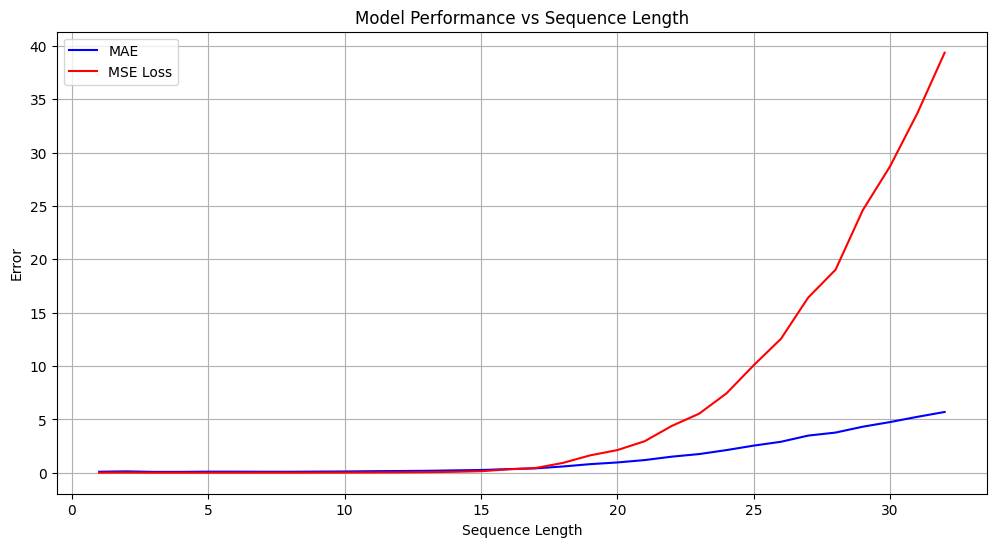

In [14]:
import torch
from torch.utils.data import DataLoader
import numpy as np

def collate_fn(batch):
    sequences = [sequence_to_tensor(item[0]).unsqueeze(-1) for item in batch]  
    labels = torch.tensor([item[1] for item in batch], dtype=torch.float32)   
    return torch.stack(sequences), labels

results = []

for i in range(1, 33):
    sequences, labels = generate_dataset(num_samples=1000, min_length=i, max_length=i)
    dataset = BitSequenceDataset(sequences, labels)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
    
    model.eval()
    loss = evaluate(model, data_loader, criterion, device)
    
    total_mae = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for batch_sequences, batch_labels in data_loader:
            batch_sequences = batch_sequences.to(device)
            batch_labels = batch_labels.to(device)
            
            predictions = model(batch_sequences).squeeze()
            
            batch_mae = torch.abs(predictions - batch_labels).sum().item()
            total_mae += batch_mae
            total_samples += batch_labels.size(0) 

    average_mae = total_mae / total_samples
    
    results.append({
        'sequence_length': i,
        'mse_loss': loss,
        'mae': average_mae
    })
    
    print(f"Sequence Length: {i:2d}, MSE Loss: {loss:.4f}, MAE: {average_mae:.4f}")

import pandas as pd
df = pd.DataFrame(results)
print("\nSummary Statistics:")
print(df.describe())

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['sequence_length'], df['mae'], 'b', label='MAE')
plt.plot(df['sequence_length'], df['mse_loss'], 'r', label='MSE Loss')
plt.xlabel('Sequence Length')
plt.ylabel('Error')
plt.title('Model Performance vs Sequence Length')
plt.legend()
plt.grid(True)
plt.show()